In [1]:
using Revise
using QuantumOptimalControl
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using DifferentialEquations: DP5, Tsit5, Vern7, Vern9, BS3
using Random
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)

┌ Info: Precompiling QuantumOptimalControl [e91afccf-c93e-44fd-aa4c-3d3ef13645c0]
└ @ Base loading.jl:1423


false

In [2]:
bs = SpinBasis(1//2)
sigmoid(x) = 1.7/(exp(-x)+1)
n_neurons = 8
Random.seed!(1)
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh),
                FastDense(n_neurons, 1))#, sigmoid))
θ = Vector{Float64}(initial_params(ann));
n_params = length(θ)
println(n_params)
#θ = 2.0*(2.0*rand(n_params) .- 1.0)
(t0, t1)=(0.0, 5.0)

97


(0.0, 5.0)

In [3]:
tsf32 = Float32(t0):Float32(t1/39):Float32(t1)
Ωs = Vector{Float32}(vcat([0.0, 0.1], 0.2*ones(36), [0.1, 0.0]))
ts = Vector{Float64}(tsf32)
function loss(p)
    c = 0.0f0
    for (i,t) in enumerate(tsf32)
        x = ann([t], p) + ann([Float32(t1)-t], p)
        c += (x[1] - Ωs[i])^2
    end
    #println(c)
    c
end
res = DiffEqFlux.sciml_train(loss, initial_params(ann), ADAM(0.1f0), maxiters = 1500)
θ = Vector{Float64}(res.u);

In [4]:
bcs(params) = (ann([t0], params)[1])^2 + (ann([t1], params)[1])^2
                 
cost = CostFunction((x,y)-> 1.0-real(x'*y), bcs)

CostFunction(var"#1#2"(), bcs)

In [5]:
trans = StateTransform(spindown(bs)=>spinup(bs));

In [6]:
coeffs(params, t) = ann([t], params)[1] #+ ann([t1-t], params)[1]
tspan = (t0, t1)
H = Hamiltonian(-0.5*sigmaz(bs), [sigmax(bs)], coeffs)
prob = QOCProblem(H, trans, tspan, cost);

In [7]:
@time sol = solve(prob, θ, ADAM(0.1); alg=Tsit5(), maxiters=100,
                  abstol=1e-5, reltol=1e-5)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58
  distance:    9.778436301233207e-6
  contraints:  8.29006259271636e-6


 73.312338 seconds (115.89 M allocations: 7.819 GiB, 53.31% gc time, 46.70% compilation time)


Solution{Float64}([-0.7142189520940786, -1.043251818326457, -0.8572654921041167, 0.29973895130666367, -0.5608396388130874, 0.6649473762876746, -2.5579053015665574, 0.6459829255569328, 0.499155252138283, 1.1518550017840068  …  -0.4849885351927344, -0.09741511962099575, 0.43067387080211345, 0.2474978378439441, -0.1266053783689631, 0.6733881080935807, -0.21084652646515337, 0.5975637497556876, -0.21882398624396573, -0.16970095836930182], [1.032322641139699, 0.5672201496462979, 0.6328536557924431, 0.5390492175345896, 0.2824116393614269, 0.10000229515357273, 0.04812196038311145, 0.13024781263770857, 0.03918933032660932, 0.0839802880487639  …  1.503653021028839e-5, 9.360275956327158e-6, 1.4028715725533658e-5, 8.812269862601418e-6, 2.5249082368672404e-5, 1.061359457832367e-5, 1.5645593321345075e-5, 9.52729496261906e-6, 6.323865727964062e-6, 9.778436301233207e-6])

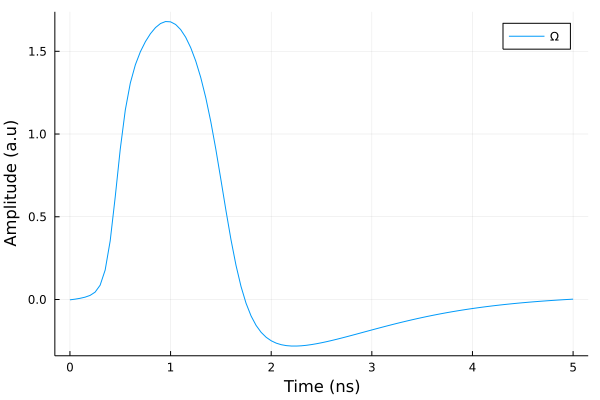

In [8]:
ts = t0:t1/100:t1
Ω(t) = coeffs(sol.params, t)[1]
f = plot(ts, Ω.(ts), label="Ω")
xlabel!("Time (ns)")
ylabel!("Amplitude (a.u)")

In [9]:
tout, psit = schroedinger_dynamic(ts, spindown(bs), H, sol.params);

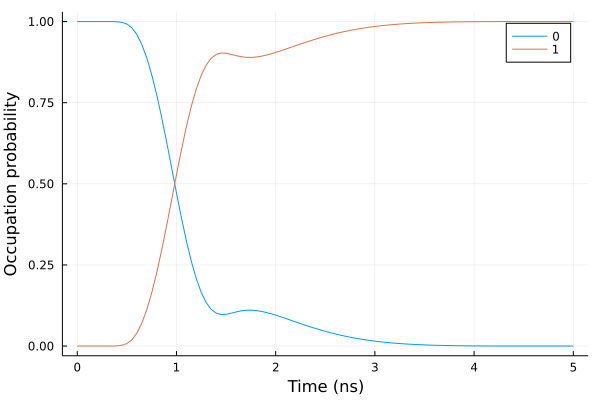

In [10]:
f = plot()
plot!(f, tout, real(expect(dm(spindown(bs)), psit)), label=string(0))
plot!(f, tout, real(expect(dm(spinup(bs)), psit)), label=string(1))
ylabel!(f, "Occupation probability")
xlabel!(f, "Time (ns)")
f